In [55]:
import time
import pandas as pd
from IPython.display import display_html
from matplotlib import pyplot as plt

## load image

In [56]:
import numpy as np
import os
import PIL
from PIL import Image, ImageOps
PIL.Image.MAX_IMAGE_PIXELS = 933120000

cached_img_load = {}

def get_files(name,path):
    if not os.path.isdir(path):
        return [(name,path)]
    else:
        targets = [
            f for f in os.listdir(path) if not os.path.isdir(os.path.join(path, f))
        ]
        return [
            (name + '/' + f, os.path.join(path, f)) for f in targets
        ]

def load_image(name,path):
    try:
        image = Image.open(path)
        # https://stackoverflow.com/questions/63947990/why-are-width-and-height-of-an-image-are-inverted-when-loading-using-pil-versus
        image = ImageOps.exif_transpose(image)

        img = np.array(image.convert('RGB'))
        dpi = image.info.get("dpi")

        print("name: ", name, 'dpi:', dpi)

        cached_img_load[name] = (img,dpi)
    except Exception as e:
        print("skip: ", path)

In [57]:
files = get_files("images", os.path.abspath("../images/opencv-rectangle"))
for n,f in files:
    load_image(n,f)

name:  images/img3.png dpi: None
name:  images/img4.png dpi: None


## detect rect

name:  images/img3.png time:  0.003001 seconds
name:  images/img4.png time:  0.000000 seconds


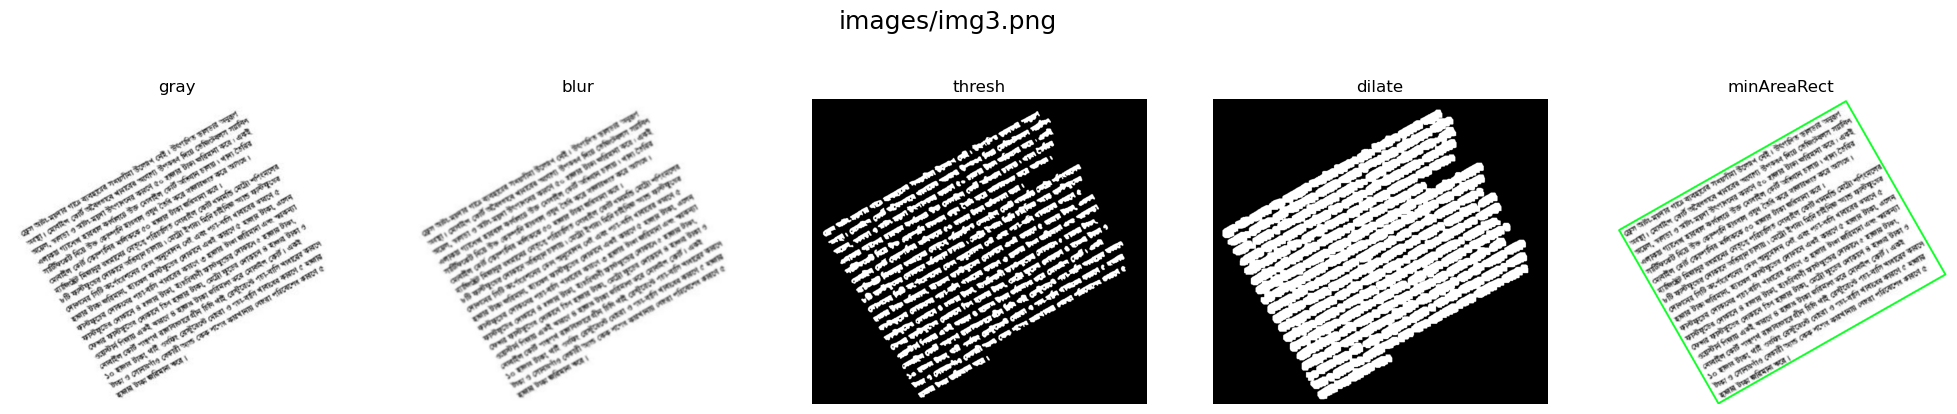

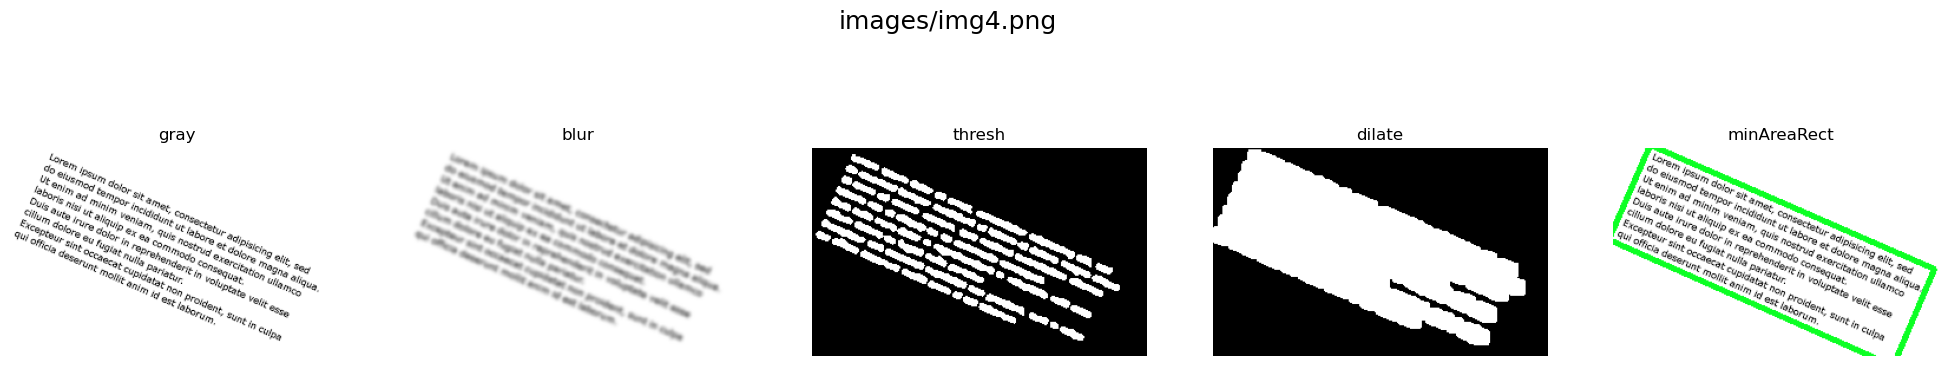

In [58]:
import cv2

cached_rect_detect = {}

for name,(img,dpi) in cached_img_load.items():
    start = time.time()

    # Resize to 150dpi
    if dpi is None:
        resize = img
    else:
        factor = np.array(dpi) / 150.0
        factor[factor < 1] = 1
        (height, width) = img.shape[:2] / factor
        size = np.intp((width, height))
        resize = cv2.resize(img, size)

    # Covert to grayscale
    gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
    # Blurs an image using a Gaussian filter
    blur = cv2.GaussianBlur(gray, (7, 7), 0)
    # Applies a fixed-level threshold to each array element
    thresh = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Returns a structuring element of the specified size and shape for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Dilates an image by using a specific structuring element
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Finds contours in a dilate image
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Get all contours to minAreaRect
    rects = []
    minAreaRect = resize.copy()
    for cnt in cnts:
        # Find a rectangle of the minimum area enclosing the input 2D point set
        rect = cv2.minAreaRect(cnt)
        box = np.intp(cv2.boxPoints(rect))
        # Draws contours outlines or filled contours
        cv2.drawContours(minAreaRect, [box], 0, (36, 255, 12), 3)

        # Collect all rectangles
        rects.append(rect)

    end = time.time()
    cached_rect_detect[name] = (rects)


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    # show the output image
    imgs_show = [
        ("gray", gray),
        ("blur", blur),
        ("thresh", thresh),
        ("dilate", dilate),
        ("minAreaRect", minAreaRect)
    ]
    fig = plt.figure(figsize=(25,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,len(imgs_show))
    for idx, (name,img) in enumerate(imgs_show):
        ax = fig.add_subplot(gs[0, idx])
        ax.set_title(name)
        ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## median angle

In [59]:
cached_angle_median = {}

for name,rects in cached_rect_detect.items():
    start = time.time()

    # Get median angle
    angles = [rect[-1] for rect in rects]
    angle_median = np.median(angles)

    end = time.time()
    cached_angle_median[name] = angle_median


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))


df = pd.DataFrame.from_dict(cached_angle_median, orient='index', columns=['angle'])
display(df)

name:  images/img3.png time:  0.000000 seconds
name:  images/img4.png time:  0.000000 seconds


,angle
images/img3.png,60.314770
images/img4.png,23.794834


## deskew image

name:  images/img3.png time:  0.001000 seconds
name:  images/img4.png time:  0.000000 seconds


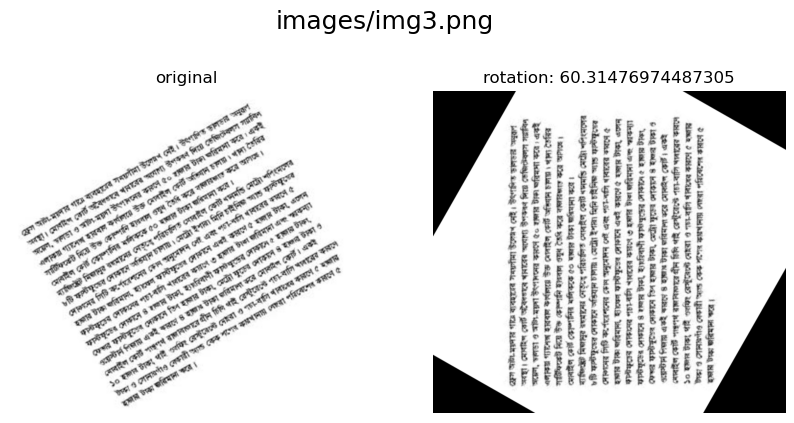

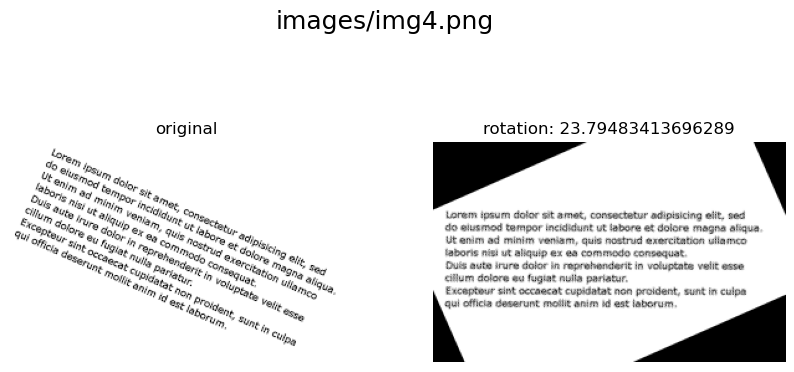

In [60]:
for name,angle in cached_angle_median.items():
    start = time.time()

    img,_ = cached_img_load[name]

    # Rotate original image
    img_center = tuple(np.array(img.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(img_center, angle, 1.0)
    img_rotated = cv2.warpAffine(img, rotation_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    end = time.time()


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    # show the output image
    imgs_show = [
        ("original", img),
        (f"rotation: {angle}", img_rotated)
    ]
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,len(imgs_show))
    for idx, (name,img) in enumerate(imgs_show):
        ax = fig.add_subplot(gs[0, idx])
        ax.set_title(name)
        ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
